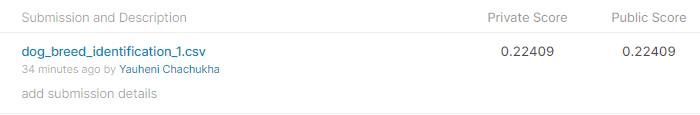

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.optimizers import SGD
import h5py


## dirs

In [ ]:
train_dir = "../input/dog-breed-identification/train"
test_dir = "../input/dog-breed-identification/test"

## jpg

Open file with labels and add ".jpg" to filenames

In [ ]:
labels = pd.read_csv("../input/dog-breed-identification/labels.csv")

In [ ]:
labels

In [ ]:
new_id = [el +".jpg" for el in labels["id"]]
labels["id"] = new_id

## ImageDataGenerator

customization of generator

In [ ]:
generator = ImageDataGenerator(
    validation_split=0.02,
    horizontal_flip = True,
    preprocessing_function = preprocess_input
)


BATCH_SIZE = 32
image_size=(331,331)

## flow_from_dataframe

load photo/images from dataframe

In [ ]:
train_generator = generator.flow_from_dataframe(
    dataframe=labels,
    directory=train_dir,
    x_col="id",
    y_col="breed",
    target_size=image_size,
    batch_size=32,
    subset="training",
)

valid_generator = generator.flow_from_dataframe(
    dataframe=labels,
    directory=train_dir,
    x_col="id",
    y_col="breed",
    target_size=image_size,
    batch_size=32,
    subset="validation",
)

## NASNetLarge

In [ ]:
nas_model=NASNetLarge(
    include_top=False, 
    weights='imagenet', 
    input_shape=(331,331,3),
)

nas_model.trainable = False
    
model = tensorflow.keras.Sequential(
    [
        nas_model,   
        layers.GlobalAveragePooling2D(),
        tensorflow.keras.layers.Dense(120, activation='softmax')
    ]
)

## compile and train
customization of model for getting weights and fiting it

In [ ]:
opt = SGD(lr=1e-3, momentum=0.9)
model.compile(
    optimizer = opt, 
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
)
model.summary()

In [ ]:
early = tensorflow.keras.callbacks.EarlyStopping(
    patience=2, 
    min_delta=0.001, 
    restore_best_weights=True
)

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
history = model.fit(
    train_generator, 
    steps_per_epoch=STEP_SIZE_TRAIN, 
    validation_data=valid_generator, 
    validation_steps=STEP_SIZE_VALID, 
    epochs=25, 
    batch_size=32, 
    callbacks=[early], 
)

## test datagen

In [ ]:
test_df = pd.read_csv("/kaggle/input/dog-breed-identification/sample_submission.csv")

In [ ]:
new_id = [el +".jpg" for el in test_df["id"]]
test_df["id"] = new_id

In [ ]:
test_datagen=ImageDataGenerator(
    preprocessing_function = preprocess_input,
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col="id",
    y_col=None,
    target_size=image_size,
    batch_size=32,
    class_mode=None,
    shuffle=False,
    
)

## prediction

In [ ]:
y_pred = model.predict(test_generator)

In [ ]:
y_pred

In [ ]:
df_sub = pd.read_csv('/kaggle/input/dog-breed-identification/sample_submission.csv')
df_sub.head()

In [ ]:
df_sub.iloc[:,1:] = y_pred
df_sub.head()

In [ ]:
final_df = df_sub.set_index('id')
final_df.to_csv('dog_breed_identification_1.csv')